# Optimizing the clipping threshold.

This notebook provides code to create figures demonstrating the optimization of the clipping threshold.


Run everything to reproduce the figures. The "define plot parameters" sets the style for the plots so may be removed.

# Define plot parameters

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib
import numpy as np

import os


import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

from matplotlib import rc
import seaborn as sns




sns.set_style('ticks')
sns.set_context('paper', font_scale=2.25)
fig_dict = {
    'figsize':[8.0, 6.0],
}
math_dict = {
    'fontset': 'cm',
}
legend_dict = {
    'fontsize': 20,
    'markerscale': 2.7,
}

savefig_dict = {
    'bbox': 'tight',
    'transparent': 'True',
    'pad_inches': 0.1,
}
axes_dict = {
    'titlesize': '20',
    'titlepad': '5.5',
    'labelsize': '25',
    'labelpad': '7',
    'formatter.use_mathtext' : 'True'
}
lines_dict = {
    'linewidth': 2.7,
}

rc('figure', **fig_dict)
rc('mathtext', **math_dict)
rc('legend', **legend_dict)
rc('savefig', **savefig_dict)
rc('axes', **axes_dict)
rc('lines', **lines_dict)

from matplotlib.font_manager import FontProperties

f_name = '/Users/ruth/Helvetica/helvetica_regular.ttf'
fm.fontManager.addfont(f_name)
font = ft.FT2Font(f_name)

custom_font = FontProperties(fname= f_name)

matplotlib.rcParams['font.sans-serif'].insert(0, font.family_name)
matplotlib.rcParams['font.family'] = font.family_name

# Define functions

In [2]:
import numpy as np
from numpy import sqrt
import scipy
from numpy.linalg import norm
from scipy.stats import norm as normal
from scipy.special import erf
from scipy.special import erfc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def risk(K,x,beta):
    return (x-beta).transpose() @ K @ (x-beta)/2

def clip(x,c):
    if len(x.shape) > 1:
        raise Exception("You need to clip a matrix")
    k = np.minimum(1, c / norm(x))
    return k * x

def clip_matrix(x,c):
    return np.minimum(1, c / norm(x, axis = 1))[:,None] * x


def hsgd_ode(vals,vecs,T,x0,beta,gamma,c, gauss):

    dt = 0.05
    v = ((x0-beta) @ U)**2 / 2
    R = np.dot(vals,v)
    Rs = [R]

    ode_time = [0]
    iters = int(T / dt)
    for i in range(iters + 1):
        t = i * dt
        R = np.dot(vals,v)

        if gauss:
            update = -gamma * 2 * v * vals* H_GAU(R,eta,c) + gamma**2 * (vals * G_GAU(R,eta,c)* (2*R + eta**2)) / 2 / d
        else:
            update = -gamma * 2 * v * vals* H_RAD(R,lam,q,c) + gamma**2 * (vals * G_RAD(R,lam,q,c)* (2*R + lam**2 * q)) / 2 / d

        v = v + dt * update

        ode_time.append(t)
        Rs.append(R)
    return np.array(Rs), ode_time


def F(z):
    return scipy.special.erf(z/np.sqrt(2)) - np.sqrt(2 / np.pi) * z * np.exp(-z**2 / 2)

def H_GAU(risk,eta,c):
    # Gaussian data gaussian noise with var eta**2
    risk = risk + eta**2/2
    return F(c / np.sqrt(2 * risk)) + c* np.exp(-c**2 / 4 / risk) / np.sqrt(3.1415 * risk)


def G_GAU(risk,eta,c):
    # Gaussian data gaussian noise with var eta**2
    varW = 2 * risk + eta**2
    risk = risk + eta**2/2

    return (2 * risk * F(c / np.sqrt(2 * risk)) + c**2 * erfc(c / np.sqrt(4 * risk))) / (varW)


def H_RAD(risk, lam, q, c):
    # Gaussian data with noise
    #
    #   lam with prob q/2
    #   0       wp 1-q
    #   -lam    wp q/2


    V = np.sqrt(2 * risk)

    M_eps = (c - lam) / V
    N_eps = (c + lam) / V
    sqrt2 = np.sqrt(2)

    p_not_clip = (q/2 * (erf(N_eps/np.sqrt(2)) + erf(M_eps/np.sqrt(2))) + (1-q) * erf(c/V/np.sqrt(2)))
    return p_not_clip


def G_RAD(risk, lam, q, c):
    # Gaussian data with noise
    #
    #   lam with prob q/2
    #   0       wp 1-q
    #   -lam    wp q/2

    V = np.sqrt(2 * risk)

    M_eps = (c - lam) / V
    N_eps = (c + lam) / V
    sqrt2 = np.sqrt(2)

    ### This is E[w^2 : w^2 < c^2]
    t1 = q/2 * F(N_eps) * V**2 + q/2 * F(M_eps) * V**2 + (1-q) * F(c/V) * V**2
    t2 = 2*(np.exp(- N_eps**2 / 2)  - np.exp(-M_eps**2/2)) * q * lam / np.sqrt(2 * 3.1415) * V
    t3 = lam**2 * q / 2 * (erf(M_eps / sqrt2) + erf(N_eps/sqrt2))

    T1 = t1 + t2 + t3

    ### This is P(w^2 > c^2)
    T2 = 1 - (q/2 * (erf(N_eps/sqrt2) + erf(M_eps/sqrt2)) + (1-q) * erf(c/V/sqrt2))

    return  (T1 + c**2 * T2) / (2*risk + lam**2 * q)


def one_pass_sgd_sched(K,A,y, x, lr_sched, clip_sched):
    r = []
    times = []

    for i,(a,b) in enumerate(zip(A,y)):
        if i % 20 == 0:
            times.append(i)
            r.append(risk(K,x,beta))

        grad = (np.dot(x,a) - b) * a

        ck = clip_sched[int(np.round(i / d / 0.01))]        # dt = 0.01 (dt should be the dt value chosen in solving the ode)
        gammak = lr_sched[int(np.round(i / d / 0.01))]
        if ck > 0:
            grad = clip(grad, ck)

        x = x - gammak * grad

    times.append(i+1)
    r.append(risk(K,x,beta))
    return np.array(r), np.array(times)


# Comparing SGD with optimal clip schedule

In [3]:
from scipy.optimize import minimize
def hsgd_ode_approx_opt(vals,vecs,T,x0,beta, gamma, init_c,  gauss):

    dt = 0.01
    v = ((x0-beta) @ U)**2 / 2
    R = np.dot(vals,v)
    Rs = [R]

    clip_sched = []
    lr_sched = []
    ode_time = [0]
    iters = int(T / dt)
    for i in range(iters):

        c = init_c * np.sqrt(2 * R + eta**2)
        
        if gauss:
            gam = gamma * np.maximum(1 / init_c, 1)
            update = -gam * 2 * v * vals* H_GAU(R,eta,c) + gam**2 * (vals * (2*R + eta**2)* G_GAU(R,eta,c)) / 2 / d

        else:
            gam = gamma / H_RAD(R,lam,q,c)
            update = -gam * 2 * v * vals* H_RAD(R,lam, q,c) + gam**2 * (vals * (2*R + lam**2 * q)* G_RAD(R,lam,q,c)) / 2 / d


        v = v + dt * update
        R = np.dot(vals,v)
        clip_sched.append(c)
        lr_sched.append(gam)

        t = i * dt

        ode_time.append(t)
        Rs.append(R)

    return np.array(Rs), ode_time, clip_sched, lr_sched

from scipy.optimize import minimize
def hsgd_ode_opt_clip(vals,vecs,T,x0,beta, gamma, gauss):

    dt = 0.01
    v = ((x0-beta) @ U)**2 / 2
    R = np.dot(vals,v)
    Rs = [R]

    clip_sched = []
    lr_sched = []
    ode_time = [0]
    iters = int(T / dt)
    for i in range(iters):

        
        if gauss:
            rat = lambda c: -H_GAU(R, eta, c)**2 / G_GAU(R, eta, c)
        else:
            rat = lambda c: -H_RAD(R, lam, q, c)**2 / G_RAD(R, lam, q, c)

        res = minimize(rat, 1, method='nelder-mead', options={'xatol': 1e-8, 'disp': False})
        c = res.x[0]
        if - rat(c) <= 1 - 0.001: # Slight tolerance
            c = 100000 # Otherwise the opt essentially failed and we can just not clip

        if gauss:
            gam = gamma / H_GAU(R,eta,c)
            update = -gam * 2 * v * vals* H_GAU(R,eta,c) + gam**2 * (vals * (2*R + eta**2)* G_GAU(R,eta,c)) / 2 / d

        else:
            gam = gamma / H_RAD(R,lam,q,c)
            update = -gam * 2 * v * vals* H_RAD(R,lam, q,c) + gam**2 * (vals * (2*R + lam**2 * q)* G_RAD(R,lam,q,c)) / 2 / d


        v = v + dt * update
        R = np.dot(vals,v)
        clip_sched.append(c)
        lr_sched.append(gam)

        t = i * dt

        ode_time.append(t)
        Rs.append(R)

    return np.array(Rs), ode_time, clip_sched, lr_sched

## For Rademacher noise

In [4]:
ambient_d = 500

# Generate covariance matrix
alpha = 1/6
U = scipy.stats.ortho_group.rvs(ambient_d)
sigmas = np.array([j**(-alpha) for j in range(1,ambient_d+1)])
K = U @ np.diag(sigmas) @ U.transpose()
sqrtK = U @ np.diag(np.sqrt(sigmas)) @ U.transpose()

gamma = 0.4
eta = 0.8
q = 0.2
lam = eta / np.sqrt(q)

T = 15

num_runs = 100

In [5]:
# Define dimension related values

d = np.trace(K)
print(f'Running with int. dim: {d}')

n = int(T * d)
gammak = gamma / d

beta = np.ones(ambient_d) * 0
x0 = np.ones(ambient_d)
x0 /= norm(x0)



init_Cs = np.linspace(0.1,5)

min_risk = 100
opt_c = -1
for init_c in init_Cs:
    ode_risk_opt_clip, ode_time_cl, clip_sched, lr_sched = hsgd_ode_approx_opt(sigmas, U, T, x0, beta, gamma, init_c, gauss = False)
    if ode_risk_opt_clip[-1] < min_risk:
        min_risk = ode_risk_opt_clip[-1]
        opt_c = init_c

print(opt_c)

Running with int. dim: 212.46308497655224
0.30000000000000004


In [6]:
ode_risk_opt_clip_approx, ode_time_cl, clip_sched_approx, lr_sched_approx = hsgd_ode_approx_opt(sigmas, U, T, x0, beta, gamma, opt_c, gauss = False)
ode_risk_opt_clip, ode_time_cl, clip_sched, lr_sched = hsgd_ode_opt_clip(sigmas, U, T, x0, beta, gamma, gauss = False)
ode_risk_no_clip, ode_time = hsgd_ode(sigmas, U, T, x0, beta, gamma,  c = 1000000, gauss = False)

sgd_clip_sched = np.array(clip_sched) * np.sqrt(d)
sgd_lr_sched = np.array(lr_sched) / d

sgd_clip_sched_approx = np.array(clip_sched_approx) * np.sqrt(d)
sgd_lr_sched_approx = np.array(lr_sched_approx) / d

In [7]:
sgd_data = []
approx_opt_data = []
unc_sgd_data = []


# num_runs = 100
for _ in tqdm(range(num_runs)):
    ##### Solve with the optimal clipping schedule 
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)
    # eps = np.random.randn(n) * eta
    eps = np.random.choice([-lam,0,lam], size = n, p = [q/2,1-q,q/2])
    b = a @ beta + eps

    sgd_risk, sgd_times = one_pass_sgd_sched(K,a,b,x0, sgd_lr_sched, sgd_clip_sched)


    ##### Solve with the vanilla SGD
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)
    # eps = np.random.randn(n) * eta
    eps = np.random.choice([-lam,0,lam], size = n, p = [q/2,1-q,q/2])
    b = a @ beta + eps

    unc_sgd_risk, _ = one_pass_sgd_sched(K,a,b,x0, gammak * np.ones(len(sgd_clip_sched)), sgd_clip_sched * 10000000)


    ##### Solve for the approximately optimal clipping schedule
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)
    # eps = np.random.randn(n) * eta
    eps = np.random.choice([-lam,0,lam], size = n, p = [q/2,1-q,q/2])
    b = a @ beta + eps

    approx_opt_risk, _ = one_pass_sgd_sched(K,a,b,x0, sgd_lr_sched_approx, sgd_clip_sched_approx)

    sgd_data.append(sgd_risk)
    unc_sgd_data.append(unc_sgd_risk)
    approx_opt_data.append(approx_opt_risk)

  0%|          | 0/100 [00:00<?, ?it/s]

<>:45: SyntaxWarning: invalid escape sequence '\i'
<>:45: SyntaxWarning: invalid escape sequence '\i'
/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59191/2806056349.py:45: SyntaxWarning: invalid escape sequence '\i'
  plt.legend([f'C-SGD Opt {confidence*100}% CI',f'C-SGD Ap. Opt. {confidence*100}% CI', f'$\infty$-SGD {confidence*100}% CI', 'Opt ODE', 'Ap. Opt. ODE', 'Unclipped ODE'])


Plotting with d=212.46308497655224


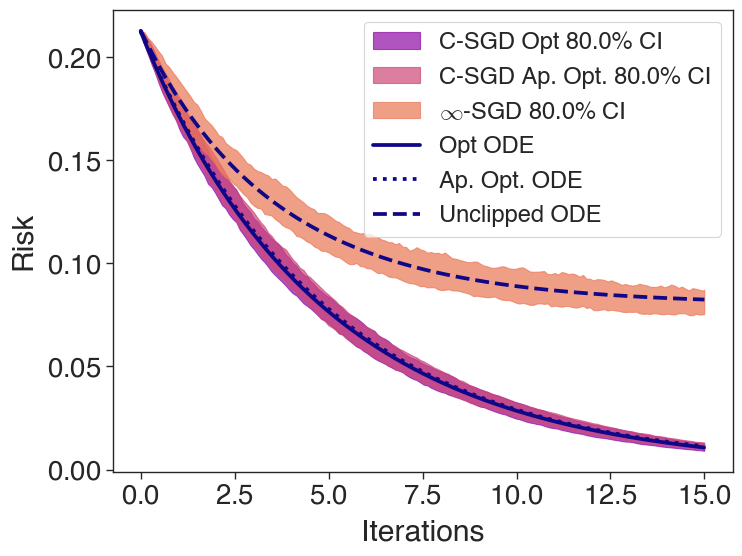

In [8]:
confidence = 0.8
q_low = (1-confidence)/2
q_high = 1/2 + confidence/2

# Set the colormap
cmap = 'plasma'

idxs = np.linspace(0,1,4)
sgd_color = plt.get_cmap(cmap)(0.3)
sgd_color_approx = plt.get_cmap(cmap)(0.5)

unc_sgd_color = plt.get_cmap(cmap)(0.66)
clip_ode_color = plt.get_cmap(cmap)(1)

ode_color = plt.get_cmap(cmap)(1)


sgd_low = np.quantile(sgd_data, q_low, axis = 0)
sgd_high = np.quantile(sgd_data, q_high, axis = 0)

unc_sgd_low = np.quantile(unc_sgd_data, q_low, axis = 0)
unc_sgd_high = np.quantile(unc_sgd_data, q_high, axis = 0)

approx_sgd_low = np.quantile(approx_opt_data, q_low, axis = 0)
approx_sgd_high = np.quantile(approx_opt_data, q_high, axis = 0)

## Plot results
print(f'Plotting with d={d}')

legend_dict = {
    'fontsize': 17,
    'markerscale': 2.7,
}
rc('legend', **legend_dict)


plt.fill_between(sgd_times / d, sgd_low, sgd_high, alpha=0.7, color = sgd_color)
plt.fill_between(sgd_times / d, approx_sgd_low, approx_sgd_high, alpha=0.7, color = sgd_color_approx)
plt.fill_between(sgd_times / d, unc_sgd_low, unc_sgd_high, alpha=0.7, color = unc_sgd_color)

plt.plot(ode_time_cl, ode_risk_opt_clip, color = ode_color)
plt.plot(ode_time_cl, ode_risk_opt_clip_approx, ':', color = ode_color)
plt.plot(ode_time, ode_risk_no_clip, '--', color = ode_color)

plt.legend([f'C-SGD Opt {confidence*100}% CI',f'C-SGD Ap. Opt. {confidence*100}% CI', f'$\infty$-SGD {confidence*100}% CI', 'Opt ODE', 'Ap. Opt. ODE', 'Unclipped ODE'])
plt.xlabel('Iterations', fontproperties=custom_font)
plt.ylabel('Risk', fontproperties=custom_font)
# plt.ylim([ode_risk[-1] * 0.8, ode_risk[0] * 1.05])
# plt.plot(sgd_times/d, np.mean(sgd_data, axis = 0))
plt.savefig('opt_clip_anisotropic_radnoise_q02_gamma04_eta08.pdf', format = 'pdf')
plt.show()

## For Gaussian noise

In [9]:
# Define dimension related values

d = np.trace(K)
print(f'Running with int. dim: {d}')

n = int(T * d)
gammak = gamma / d
beta = np.ones(ambient_d) * 0
x0 = np.ones(ambient_d)
x0 /= norm(x0)


init_Cs = np.linspace(0.1,20)

min_risk = 100
opt_c = -1
for init_c in init_Cs:
    ode_risk_opt_clip, ode_time_cl, clip_sched, lr_sched = hsgd_ode_approx_opt(sigmas, U, T, x0, beta, gamma, init_c, gauss = True)
    if ode_risk_opt_clip[-1] <= min_risk:
        min_risk = ode_risk_opt_clip[-10]
        opt_c = init_c

ode_risk_opt_clip_approx, ode_time_cl, clip_sched_approx, lr_sched_approx = hsgd_ode_approx_opt(sigmas, U, T, x0, beta, gamma, opt_c, gauss = True)
ode_risk_opt_clip, ode_time_cl, clip_sched, lr_sched = hsgd_ode_opt_clip(sigmas, U, T, x0, beta, gamma, gauss = True)
ode_risk_no_clip, ode_time = hsgd_ode(sigmas, U, T, x0, beta, gamma,  c = 1000000, gauss = True)

sgd_clip_sched = np.array(clip_sched) * np.sqrt(d)
sgd_lr_sched = np.array(lr_sched) / d

sgd_clip_sched_approx = np.array(clip_sched_approx) * np.sqrt(d)
sgd_lr_sched_approx = np.array(lr_sched_approx) / d


# p_clip = [H_RAD(risk, lam, q, c) for risk, c in zip(ode_risk_opt_clip, clip_sched)]
# g_clip = [G_RAD(risk, lam, q, c) for risk, c in zip(ode_risk_opt_clip, clip_sched)]

# plt.plot(p_clip)
# plt.plot(g_clip)
print(opt_c)

Running with int. dim: 212.46308497655224
0.9122448979591836


In [10]:
sgd_data = []
approx_opt_data = []
unc_sgd_data = []


# num_runs = 100
for _ in tqdm(range(num_runs)):
    ##### Solve with the optimal clipping schedule 
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)
    eps = np.random.randn(n) * eta
    # eps = np.random.choice([-lam,0,lam], size = n, p = [q/2,1-q,q/2])
    b = a @ beta + eps

    sgd_risk, sgd_times = one_pass_sgd_sched(K,a,b,x0, sgd_lr_sched, sgd_clip_sched)


    ##### Solve with the vanilla SGD
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)
    eps = np.random.randn(n) * eta
    # eps = np.random.choice([-lam,0,lam], size = n, p = [q/2,1-q,q/2])
    b = a @ beta + eps

    unc_sgd_risk, _ = one_pass_sgd_sched(K,a,b,x0, gammak * np.ones(len(sgd_clip_sched)), sgd_clip_sched * 10000000)


    ##### Solve for the approximately optimal clipping schedule
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)
    eps = np.random.randn(n) * eta
    # eps = np.random.choice([-lam,0,lam], size = n, p = [q/2,1-q,q/2])
    b = a @ beta + eps

    approx_opt_risk, _ = one_pass_sgd_sched(K,a,b,x0, sgd_lr_sched_approx, sgd_clip_sched_approx)

    sgd_data.append(sgd_risk)
    unc_sgd_data.append(unc_sgd_risk)
    approx_opt_data.append(approx_opt_risk)

  0%|          | 0/100 [00:00<?, ?it/s]

<>:39: SyntaxWarning: invalid escape sequence '\i'
<>:39: SyntaxWarning: invalid escape sequence '\i'
/var/folders/5_/3btrhz8s40584lcy3hwpxz_80000gn/T/ipykernel_59191/3577413064.py:39: SyntaxWarning: invalid escape sequence '\i'
  plt.legend([f'C-SGD Opt {confidence*100}% CI',f'C-SGD Ap. Opt. {confidence*100}% CI', f'$\infty$-SGD {confidence*100}% CI', 'Opt ODE', 'Ap. Opt. ODE', 'Unclipped ODE'])


Plotting with d=212.46308497655224


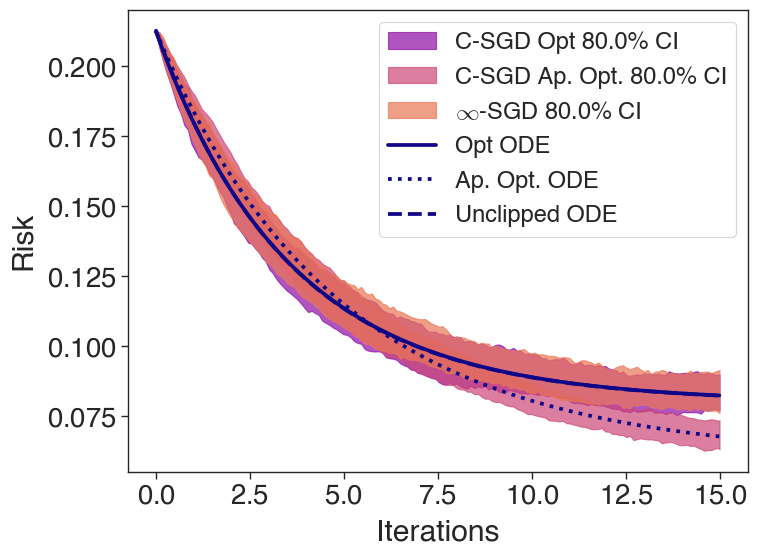

In [11]:
confidence = 0.8
q_low = (1-confidence)/2
q_high = 1/2 + confidence/2

# Set the colormap
cmap = 'plasma'

idxs = np.linspace(0,1,4)
sgd_color = plt.get_cmap(cmap)(0.3)
sgd_color_approx = plt.get_cmap(cmap)(0.5)

unc_sgd_color = plt.get_cmap(cmap)(0.66)
clip_ode_color = plt.get_cmap(cmap)(1)

ode_color = plt.get_cmap(cmap)(1)


sgd_low = np.quantile(sgd_data, q_low, axis = 0)
sgd_high = np.quantile(sgd_data, q_high, axis = 0)

unc_sgd_low = np.quantile(unc_sgd_data, q_low, axis = 0)
unc_sgd_high = np.quantile(unc_sgd_data, q_high, axis = 0)

approx_sgd_low = np.quantile(approx_opt_data, q_low, axis = 0)
approx_sgd_high = np.quantile(approx_opt_data, q_high, axis = 0)

## Plot results
print(f'Plotting with d={d}')


plt.fill_between(sgd_times / d, sgd_low, sgd_high, alpha=0.7, color = sgd_color)
plt.fill_between(sgd_times / d, approx_sgd_low, approx_sgd_high, alpha=0.7, color = sgd_color_approx)
plt.fill_between(sgd_times / d, unc_sgd_low, unc_sgd_high, alpha=0.7, color = unc_sgd_color)

plt.plot(ode_time_cl, ode_risk_opt_clip, color = ode_color)
plt.plot(ode_time_cl, ode_risk_opt_clip_approx, ':', color = ode_color)
plt.plot(ode_time, ode_risk_no_clip, '--', color = ode_color)

plt.legend([f'C-SGD Opt {confidence*100}% CI',f'C-SGD Ap. Opt. {confidence*100}% CI', f'$\infty$-SGD {confidence*100}% CI', 'Opt ODE', 'Ap. Opt. ODE', 'Unclipped ODE'])
plt.xlabel('Iterations', fontproperties=custom_font)
plt.ylabel('Risk', fontproperties=custom_font)
# plt.ylim([ode_risk[-1] * 0.8, ode_risk[0] * 1.05])
# plt.plot(sgd_times/d, np.mean(sgd_data, axis = 0))
plt.savefig('opt_clip_anisotropic_gaussnoise_gamma04_eta08.pdf', format = 'pdf')
plt.show()